## GoogleNet MNIST Classification
* Author: Ziad Tamim
* Description: Training Googlenet with MNIST Dataset. Loading data, building the Lenet achetiture using tensorflow, training the model, and evaluating its performance.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


2024-04-30 10:14:47.864309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 10:14:47.864424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 10:14:47.949886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading MNIST Dataset
* Loading the data using pandas read_csv function
* Normalising pixle values
* Convert to 3 channels
* Resizing images [75 x 75]

In [3]:
# Load the training and test data from CSV files
train_df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv')

# Assuming the first column is 'label' and the rest are pixel values
y_train = train_df['label'].values
x_train = train_df.drop(['label'], axis=1).values.reshape(-1, 28, 28, 1) / 255.0  # Normalize pixel values
y_test = test_df['label'].values
x_test = test_df.drop(['label'], axis=1).values.reshape(-1, 28, 28, 1) / 255.0  # Normalize pixel values

# Convert to 3 channels
x_train = np.repeat(x_train, 3, axis=3)
x_test = np.repeat(x_test, 3, axis=3)

# Optionally resize images to a more suitable size for GoogLeNet
x_train = tf.image.resize(x_train, [75, 75])
x_test = tf.image.resize(x_test, [75, 75])


# Building the Googlenet architechture using tensorflow

In [4]:
def inception_block(x, filters):
    t1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    
    t2 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    t2 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(t2)
    
    t3 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    t3 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(t3)
    
    t4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    t4 = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(t4)
    
    output = layers.concatenate([t1, t2, t3, t4], axis=-1)
    return output

def build_googlenet():
    inputs = tf.keras.Input(shape=(75, 75, 3))
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_googlenet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 38,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 19,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 19, 19,    │    110,784 │ max_pooling2d[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 10, 10,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 10, 10,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 10, 10,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 10, 10,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 10, 10,    │    110,720 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 10, 10,    │     12,832 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 10, 10,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 10, 10,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 10, 10,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 10, 10,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 798,394 (3.05 MB)

 Trainable params: 798,394 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model
* 15 epochs
* 64 batch size

In [5]:
history = model.fit(x_train, y_train, batch_size=64, epochs=15, validation_data=(x_test, y_test))


Epoch 1/15
  6/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.1121 - loss: 2.3130 

I0000 00:00:1714472193.514829     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.6592 - loss: 0.9337 - val_accuracy: 0.9838 - val_loss: 0.0515
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9762 - loss: 0.0827 - val_accuracy: 0.9879 - val_loss: 0.0379
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9835 - loss: 0.0555 - val_accuracy: 0.9905 - val_loss: 0.0285
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9870 - loss: 0.0447 - val_accuracy: 0.9917 - val_loss: 0.0254
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9899 - loss: 0.0355 - val_accuracy: 0.9887 - val_loss: 0.0337
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9915 - loss: 0.0289 - val_accuracy: 0.9919 - val_loss: 0.0249
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9915 - loss: 0.0288 - val_accuracy: 0.9922 - val_loss: 0.0224
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9935 - loss: 0.0217 - val_accurac

# visualising Training Accuracy and Loss

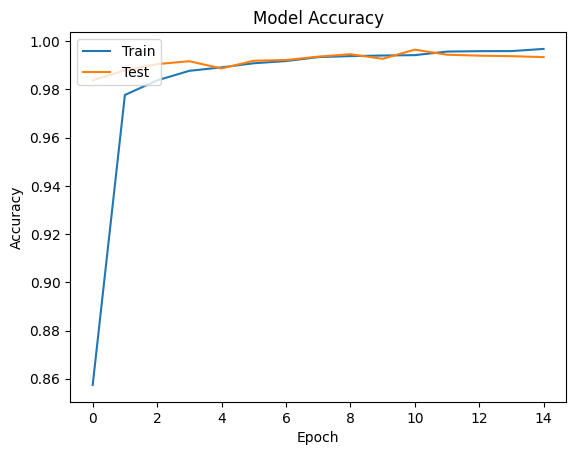

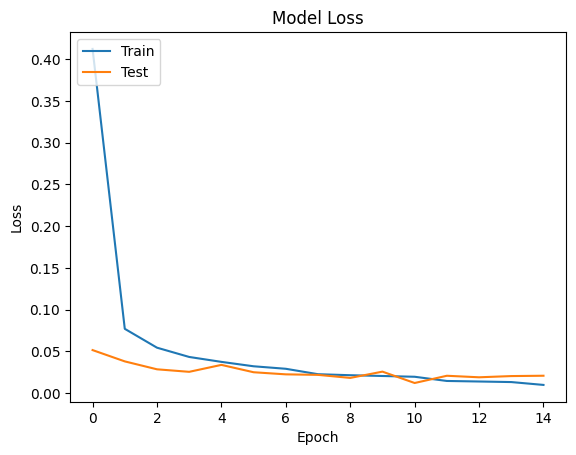

In [6]:
import matplotlib.pyplot as plt
# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Evaluaing the model using confusion matrix and classification report

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


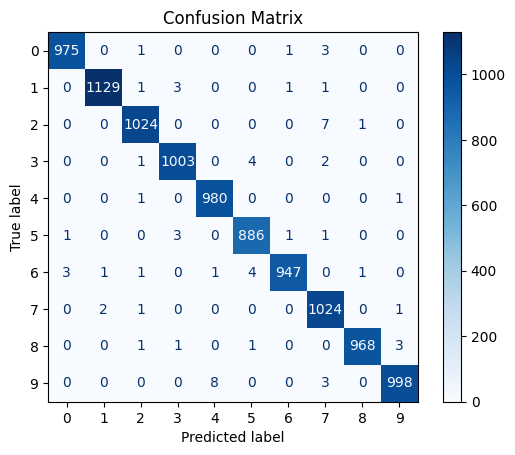

Classification Report:
               precision    recall  f1-score   support

           0     0.9959    0.9949    0.9954       980
           1     0.9973    0.9947    0.9960      1135
           2     0.9932    0.9922    0.9927      1032
           3     0.9931    0.9931    0.9931      1010
           4     0.9909    0.9980    0.9944       982
           5     0.9899    0.9933    0.9916       892
           6     0.9968    0.9885    0.9927       958
           7     0.9837    0.9961    0.9899      1028
           8     0.9979    0.9938    0.9959       974
           9     0.9950    0.9891    0.9920      1009

    accuracy                         0.9934     10000
   macro avg     0.9934    0.9934    0.9934     10000
weighted avg     0.9934    0.9934    0.9934     10000



In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predictions for the test set
prediction_scores = model.predict(x_test)
predicted_labels = np.argmax(prediction_scores, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, predicted_labels, digits=4)
print('Classification Report:\n', report)


## Predicting an image lable from the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


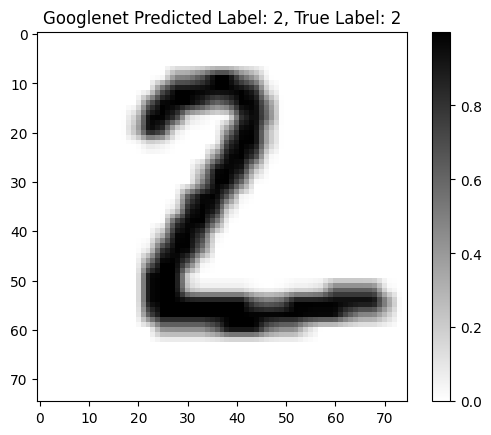

In [8]:
# Inference on a single image
img_index = 1
selected_image = x_test[img_index]
selected_label = y_test[img_index]
image_for_inference = np.expand_dims(selected_image, 0)
predictions = model.predict(image_for_inference)
predicted_label = np.argmax(predictions)

# Display the image
plt.figure()
plt.imshow(selected_image[:, :, 0], cmap=plt.cm.binary)
plt.title(f'Googlenet Predicted Label: {predicted_label}, True Label: {selected_label}')
plt.colorbar()
plt.grid(False)
plt.show()